<a href="https://colab.research.google.com/github/covierob/ads-image-classifier/blob/main/ADS_Classifier_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Image Dataset Download and Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Image Recognition

### Initialization

In [ ]:
import warnings
warnings.filterwarnings('ignore')

Libraries laden und Matplotlib-Plots im Notebook speichern.
With this backend, the output of plotting commands is displayed inline within frontends like the Jupyter notebook, directly below the code cell that produced it. The resulting plots will then also be stored in the notebook document. When using the 'inline' backend, your matplotlib graphs will be included in your notebook, next to the code.

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

fastai sits on top of PyTorch, which provides the foundation for our work. fastai is the first deep learning library to provide a single consistent interface to all the most commonly used deep learning applications for vision, text, tabular data, time series, and collaborative filtering. Google was the first to announce its support. Keine Installation nötig.

In [ ]:
from fastai.vision import * #fastai is a deep learning and ai library. in google colab, there is no installation of it needed
from fastai.metrics import error_rate #fastai.metrics is used to train models; error_rate is a function of this metric

PATH is the path containing all the class folders. You may keep './foods' if you are using foods dataset. Otherwise, specify the path of your folders.

In [ ]:
bs = 64  #batch size: if your GPU is running out of memory, set a smaller batch size, i.e 16
sz = 224 #image size
PATH = '/content/drive/MyDrive/Colab Notebooks/foods' 

For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again. We can keep doing this procedure until we have propagated all samples through of the network. Problem might happen with the last set of samples. In our example, we've used 1050 which is not divisible by 100 without remainder. The simplest solution is just to get the final 50 samples and train the network.

Let's retrieve the image classes,

In [ ]:
classes = []
for d in os.listdir(PATH): #for each object in the given path
    if os.path.isdir(os.path.join(PATH, d)) and not d.startswith('.'): #...whose name does not start with "." (this makes sure that systemfiles etc are not included)
        classes.append(d) #adds the object "d" to the list
print ("Wir haben ", len(classes), "Klassen:\n", classes)            

Wir haben  7 Klassen:
 ['models', 'risotto', 'ramen', 'sushi', 'steak', 'grapes', 'pizza']


Let's verify there are not any corrupt images that cannot be read. If found any, they will simply be deleted.

- Grayscale?
- Resize?

In [ ]:
for c in classes:
    print ("Klasse:", c)
    verify_images(os.path.join(PATH, c), delete=True); #tries to open the images with a fastai function for checking images. If it doesn't work, the image is deleted

Klasse: models
Klasse: risotto


Klasse: ramen


Klasse: sushi


Klasse: steak


Klasse: grapes


Klasse: pizza


In [ ]:
for img in os.listdir(path):
  img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE)
  plt.imshow(img_array, cmap='gray')
  plt.show()
  break

In [ ]:
print(img_array.shape)

AttributeError: ignored

In [ ]:
IMG_SIZE = 80

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
plt.imshow(new_array, cmap='gray')
plt.show()

error: ignored

## 3. Creating and training the classifier

Let's split our dataset to 80% for training and 20% for validation

- Was macht bs und sz?



In [ ]:
data  = ImageDataBunch.from_folder(PATH, ds_tfms=get_transforms(), size=sz, bs=bs, valid_pct=0.2).normalize(imagenet_stats) #ImageDataBunch is a class from fastai. is here used to split the data. Only the validation-percentage is given.

In [ ]:
print ("Wir haben", len(data.train_ds), "Trainingsbilder und", len(data.valid_ds), "Validationsbilder." )

Wir haben 949 Trainingsbilder und 237 Validationsbilder.


Let's visualize some images from different classes,

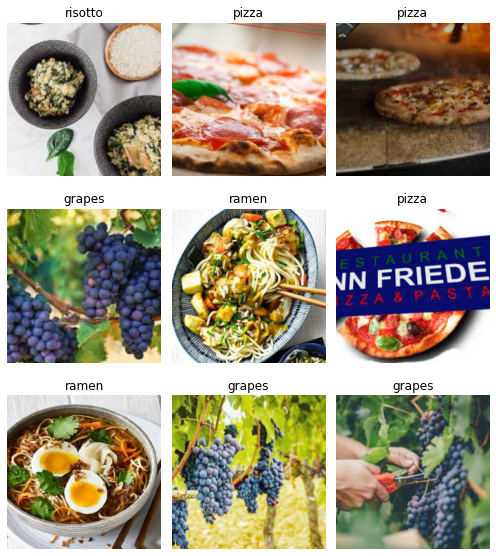

In [ ]:
data.show_batch(rows=3, figsize=(7,8))

Let's build our Deep Convolutional Neural Network (CNN),

---



Command explained: learn = cnn_learner(data, models.resnet34, metrics=accuracy) (see above)
.fit_one_cycle = the one_cycle_policy has three steps:
1. We progressively increase our learning rate from lr_max/div_factor to lr_max and at the same time we progressively decrease our momentum from mom_max to mom_min.
2. We do the exact opposite: we progressively decrease our learning rate from lr_max to lr_max/div_factor and at the same time we progressively increase our momentum from mom_min to mom_max.
3. We further decrease our learning rate from lr_max/div_factor to lr_max/(div_factor x 100) and we keep momentum steady at mom_max.

Variationsmöglichkeit: mal mit .fit anstatt .fit_one_cycle versuchen?
für was steht "4" --> Anzahl Epochen
max_lr=slice --> gibt learning rate zwischen 0.001 und 0.01 an?

In [ ]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy) #I think we should try resnet50 (the number stands for the amount of layers (depth))

- cnn_learner fastai -> is downloading Pytorch model automatically (pre-trained model)
- Unterricht Elena ResNet

*italicized text*## 4. Model Optimization

The CNN architecture used here is [ResNet34](https://arxiv.org/pdf/1512.03385.pdf). ResNet architecture has had great success within the last few years and still considered state-of-the-art, so I believe there is great value in discussing it a bit. If you are interested solely in getting the Image Recognizer to work, feel free to skip the next few paragraphs.

First, what’s CNN again? We can think of a Convolutional Neural Network (CNN or convNet) as a list of layers that transform the image volume into an output volume, which can be a class score as it is the case in this tutorial. For an in-depth read, I would highly recommend [Convolutional Neural Networks](http://cs231n.github.io/convolutional-networks/) from Stanford’s CS231 class.

What is special about ResNet architecture is how it tackles _the degradation problem_ most common in deep networks, where the model accuracy gets saturated and then degrades rapidly. It is important to note here that although some assume that the core idea behind ResNets is overcoming the notorious _vanishing gradient problem_, where gradients get infinitely small as they back-propagate to earlier layers of the network, this is not quite true. 

Resnet architecture introduces an "identity shortcut connection" or often referred to as a "skip connection", which skips one or more layers. The shortcut connections simply perform identity mappings, and their outputs are added to
the outputs of the stacked layers, as shown in the figure below. The skip function creates what is known as a residual block, F(x) in our figure, and that's where the name Residual Nets (ResNets) came from.  

<img width="286" alt="Tutorial1_img1" src="https://user-images.githubusercontent.com/8379428/56853841-f6429600-68e1-11e9-9cf3-a2ca324c277b.png">

Comprehensive empirical evidence has shown that the addition of these identity mappings allows the model to go deeper without degradation in performance and such networks are easier to optimize than plain stacked layers. There are several variants of ResNets, such as ResNet50, ResNet101, ResNet152; the number represents the number of layers (depth) of the ResNet. 

<img width="216" alt="Tutorial1_img1" src="https://user-images.githubusercontent.com/8379428/56853787-5e44ac80-68e1-11e9-9750-e9f5e417cf1e.png">

Image credit: [ResNet34](https://arxiv.org/pdf/1512.03385.pdf)

In this tutorial, we are using ResNet34. Feel free to try any of the other ResNet models by simply replacing `models.resnet34` by `models.resnet50` for instance, but bare in mind that increasing the number of layers would require more GPU memory.

Let's now pick the appropriate learning rate parameter.
We have already seen how to implement the learning rate finder. Begin to train the model while increasing the learning rate from a very low to a very large one, stop when the loss starts to really get out of control. Plot the losses against the learning rates and pick a value a bit before the minimum, where the loss still improves.
https://towardsdatascience.com/understanding-learning-rates-and-how-it-improves-performance-in-deep-learning-d0d4059c1c10

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


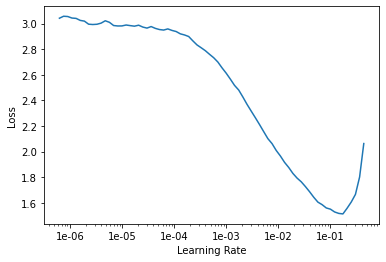

In [ ]:
learn.lr_find(); 
learn.recorder.plot()

Instructions for picking the learning rate; https://stackoverflow.com/questions/61172627/choosing-the-learning-rate-using-fastais-learn-lr-find
we need to pick a value, where the slope is "dropping" fast towards the minimum. not a value at the actual minimum or near "links unde" or "rechts obe".
learning rate is the "size of the step" we take to find the minimum.

Use the above plot to pick adequate learning rates for your model. We need two learning rates since we are using [cyclic learning rates](https://arxiv.org/pdf/1506.01186.pdf):

- The first learning rate is just before the loss starts to increase, preferably 10x smaller than the rate at which the loss starts to increase. For instance, 1e-02 for our foods dataset. 

- The second learning rate is 10x smaller than the first learning rate, so 1e-03 in our example.

The plot will be different for your dataset, so make sure to pick these two learning rates accordingly.

<br>Replace your chosen learning rates in the **slice** function below and let's train the model.

In [ ]:
learn.fit_one_cycle(4, max_lr=slice(1e-3,1e-2)) 

epoch,train_loss,valid_loss,accuracy,time
0,1.331484,0.432261,0.924051,02:52
1,0.792582,0.309488,0.945148,02:50
2,0.538951,0.239662,0.932489,02:50
3,0.408037,0.207568,0.940928,03:02


Great, we achieved a high classification accuracy with only a few lines of code and without much tuning of the parameters.

We are DONE but let's further interpret the results.

## 5. Results Interpretation and Visualization

We can start by visualizing a confusion matrix. The diagonal elements represent 
the number of images for which the predicted label is equal to the true label, while off-diagonal elements are those that are mislabeled by the classifier.

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

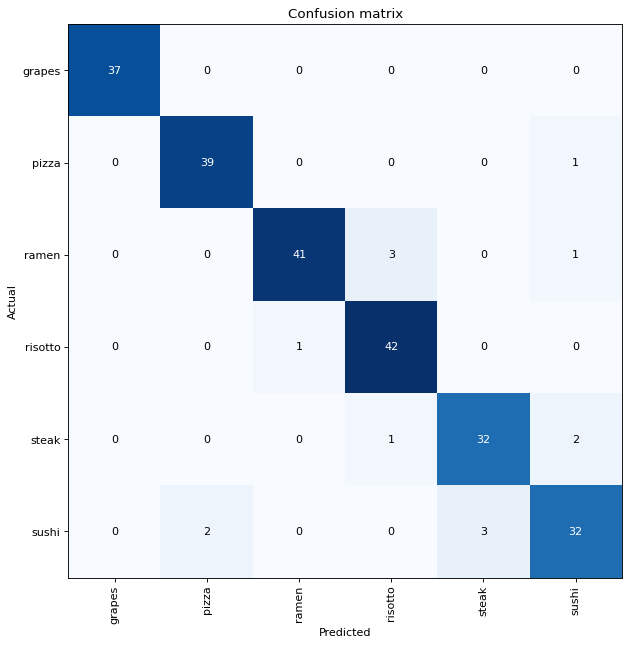

In [ ]:
interp.plot_confusion_matrix(figsize=(8,8), dpi=80)

Sushi wird am meisten mit Ramen verwechselt.
We can also plot images with top losses; in other words, the images that the model was most confused about. A high loss implies high confidence about the wrong answer. 

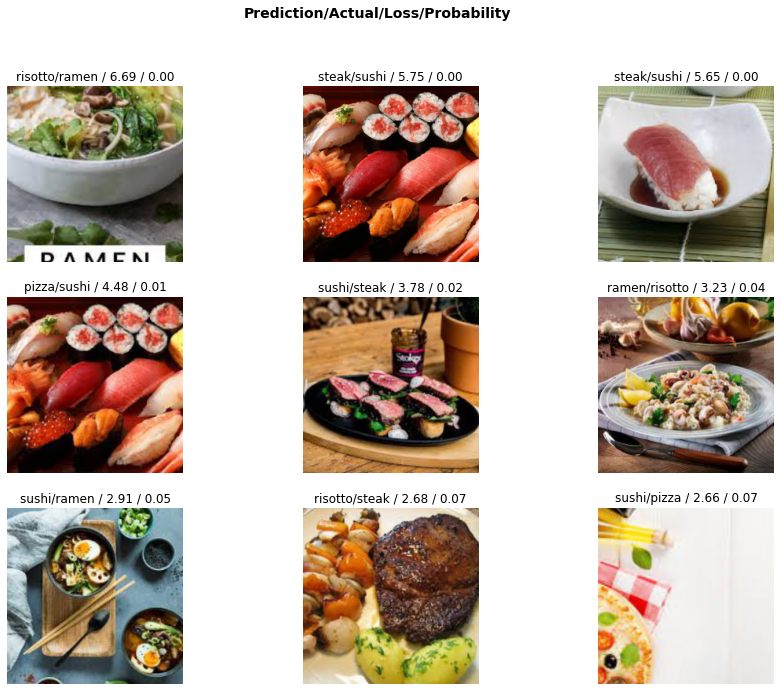

In [ ]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=False)

Images are shown along with top losses:<br> 
prediction label / actual label / loss / probability of actual image class.

## 6. Testing the model on a new image

Let's now feed the model a new image it never seen before and see how well it classifies it. 

Upload the image to the same folder of this notebook.

Das ist pizza.


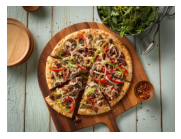

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Testimages' #The path of your test image
img = open_image(get_image_files(path)[1])
pred_class,pred_idx,outputs = learn.predict(img)
img.show()
print ("Das ist", str(pred_class) + ".")

In [ ]:
!pip install Google-Images-Search
!pip install --upgrade google-api-python-client google-auth-httplib2 google-auth-oauthlib
!pip install pydrive
!pip install google-auth
from pydrive.auth import GoogleAuth
!pip install google-api-python-client google-auth-httplib2 google-auth-oauthlibfrom pydrive.auth
from pydrive.drive import GoogleDrive
import os
g_login = GoogleAuth()
g_login.LocalWebserverAuth()
drive = GoogleDrive(g_login)

     |████████████████████████████████| 71kB 4.3MB/s 
  Found existing installation: google-api-python-client 2.6.0
    Uninstalling google-api-python-client-2.6.0:
      Successfully uninstalled google-api-python-client-2.6.0
  Using cached https://files.pythonhosted.org/packages/0c/95/fa581d3e05251ff5b30343edac489898305f41f6eeee9873f42633d93a94/google_api_python_client-2.6.0-py2.py3-none-any.whl
Requirement already up-to-date: google-auth-httplib2 in /usr/local/lib/python3.7/dist-packages (0.1.0)
Requirement already up-to-date: google-auth-oauthlib in /usr/local/lib/python3.7/dist-packages (0.4.4)
ERROR: google-images-search 1.3.8 has requirement google-api-python-client~=1.7, but you'll have google-api-python-client 2.6.0 which is incompatible.
ERROR: earthengine-api 0.1.266 has requirement google-api-python-client<2,>=1.12.1, but you'll have google-api-python-client 2.6.0 which is incompatible.
  Found existing installation: google-api-python-client 1.12.8
    Uninstalling google-a

InvalidConfigError: ignored

## 7. Ethik